In [76]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Read the data
heart_data = pd.read_csv('/content/heart_disease_uci.csv')
heart_data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [78]:
heart_data['num'].value_counts()

,count
num,
0,411
1,265
2,109
3,107
4,28


In [79]:
#Converting num variable to binary format
# Convert 'num' to binary format (1 for heart disease, 0 for no heart disease)
heart_data['num'] = (heart_data['num'] > 0).astype(int)
heart_data['num'].value_counts()

,count
num,
1,509
0,411


In [80]:
# Get a summary of the data
print(heart_data.describe())

               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.553261  
std      0.935653    0.497426  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    1.000000  
max      3.000

In [81]:
# Determine types of variables
print(heart_data.dtypes)

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object


In [82]:
missing_values = heart_data.isnull().sum()
print(missing_values)

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [83]:
# Identify categorical and numerical features
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'dataset']

In [84]:
# Create age groups for baseline model
def categorize_age(age):
    if age <= 47:
        return "young age"
    elif age <= 53:
        return "middle aged"
    else:
        return "older age"

heart_data['age_group'] = heart_data['age'].apply(categorize_age)
print("\nAge group distribution:")
print(heart_data['age_group'].value_counts())


Age group distribution:
age_group
older age      499
young age      239
middle aged    182
Name: count, dtype: int64


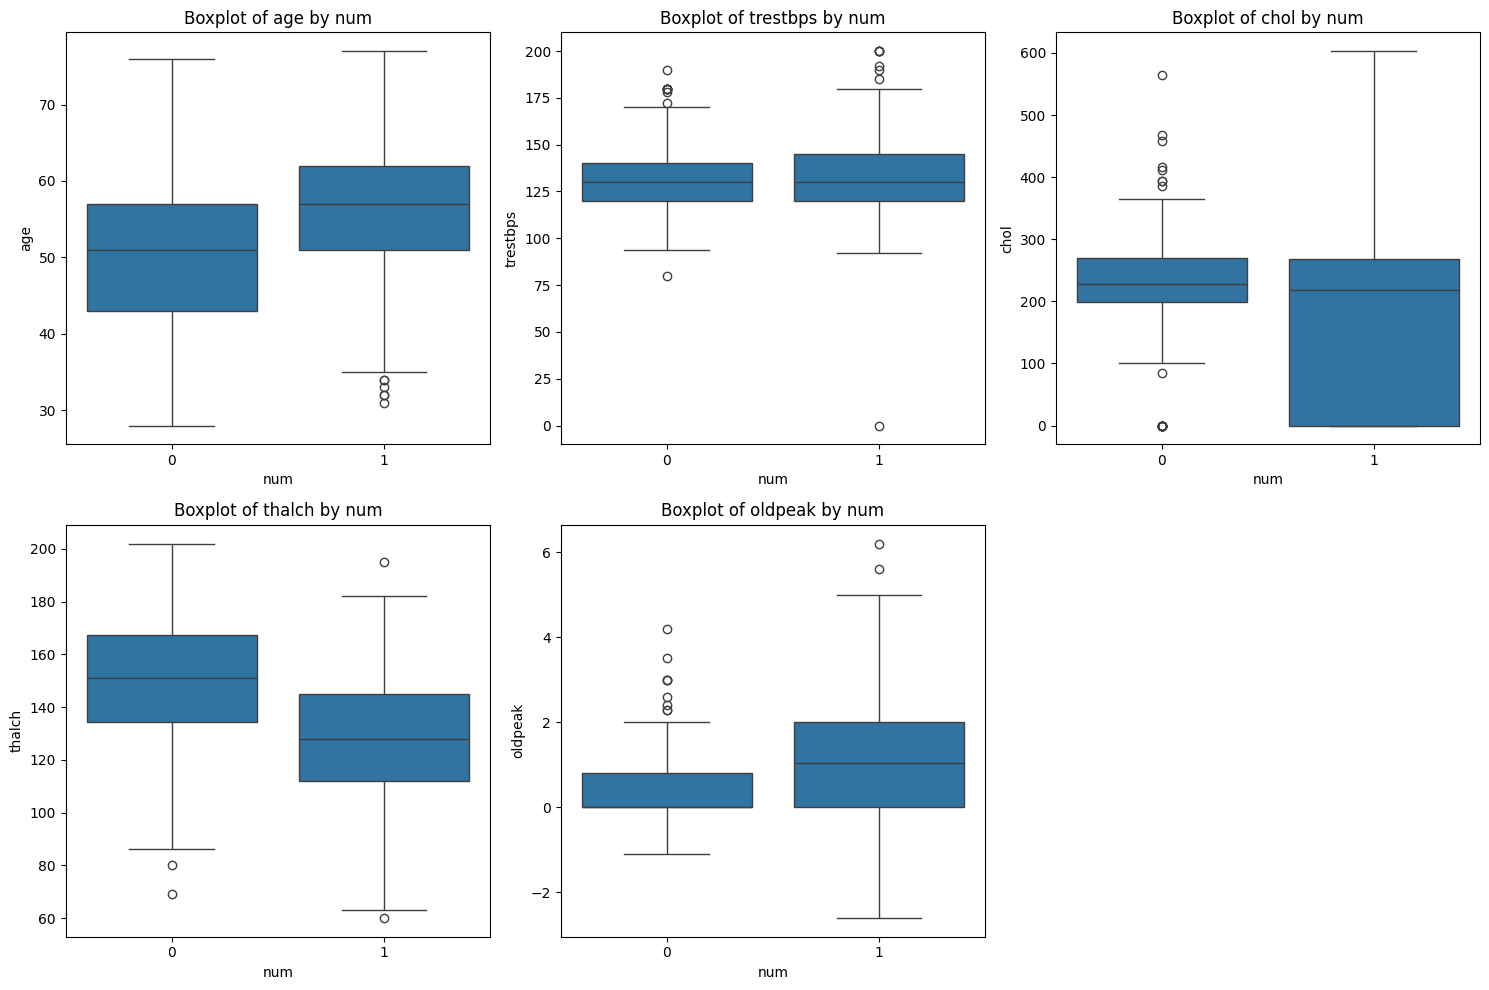

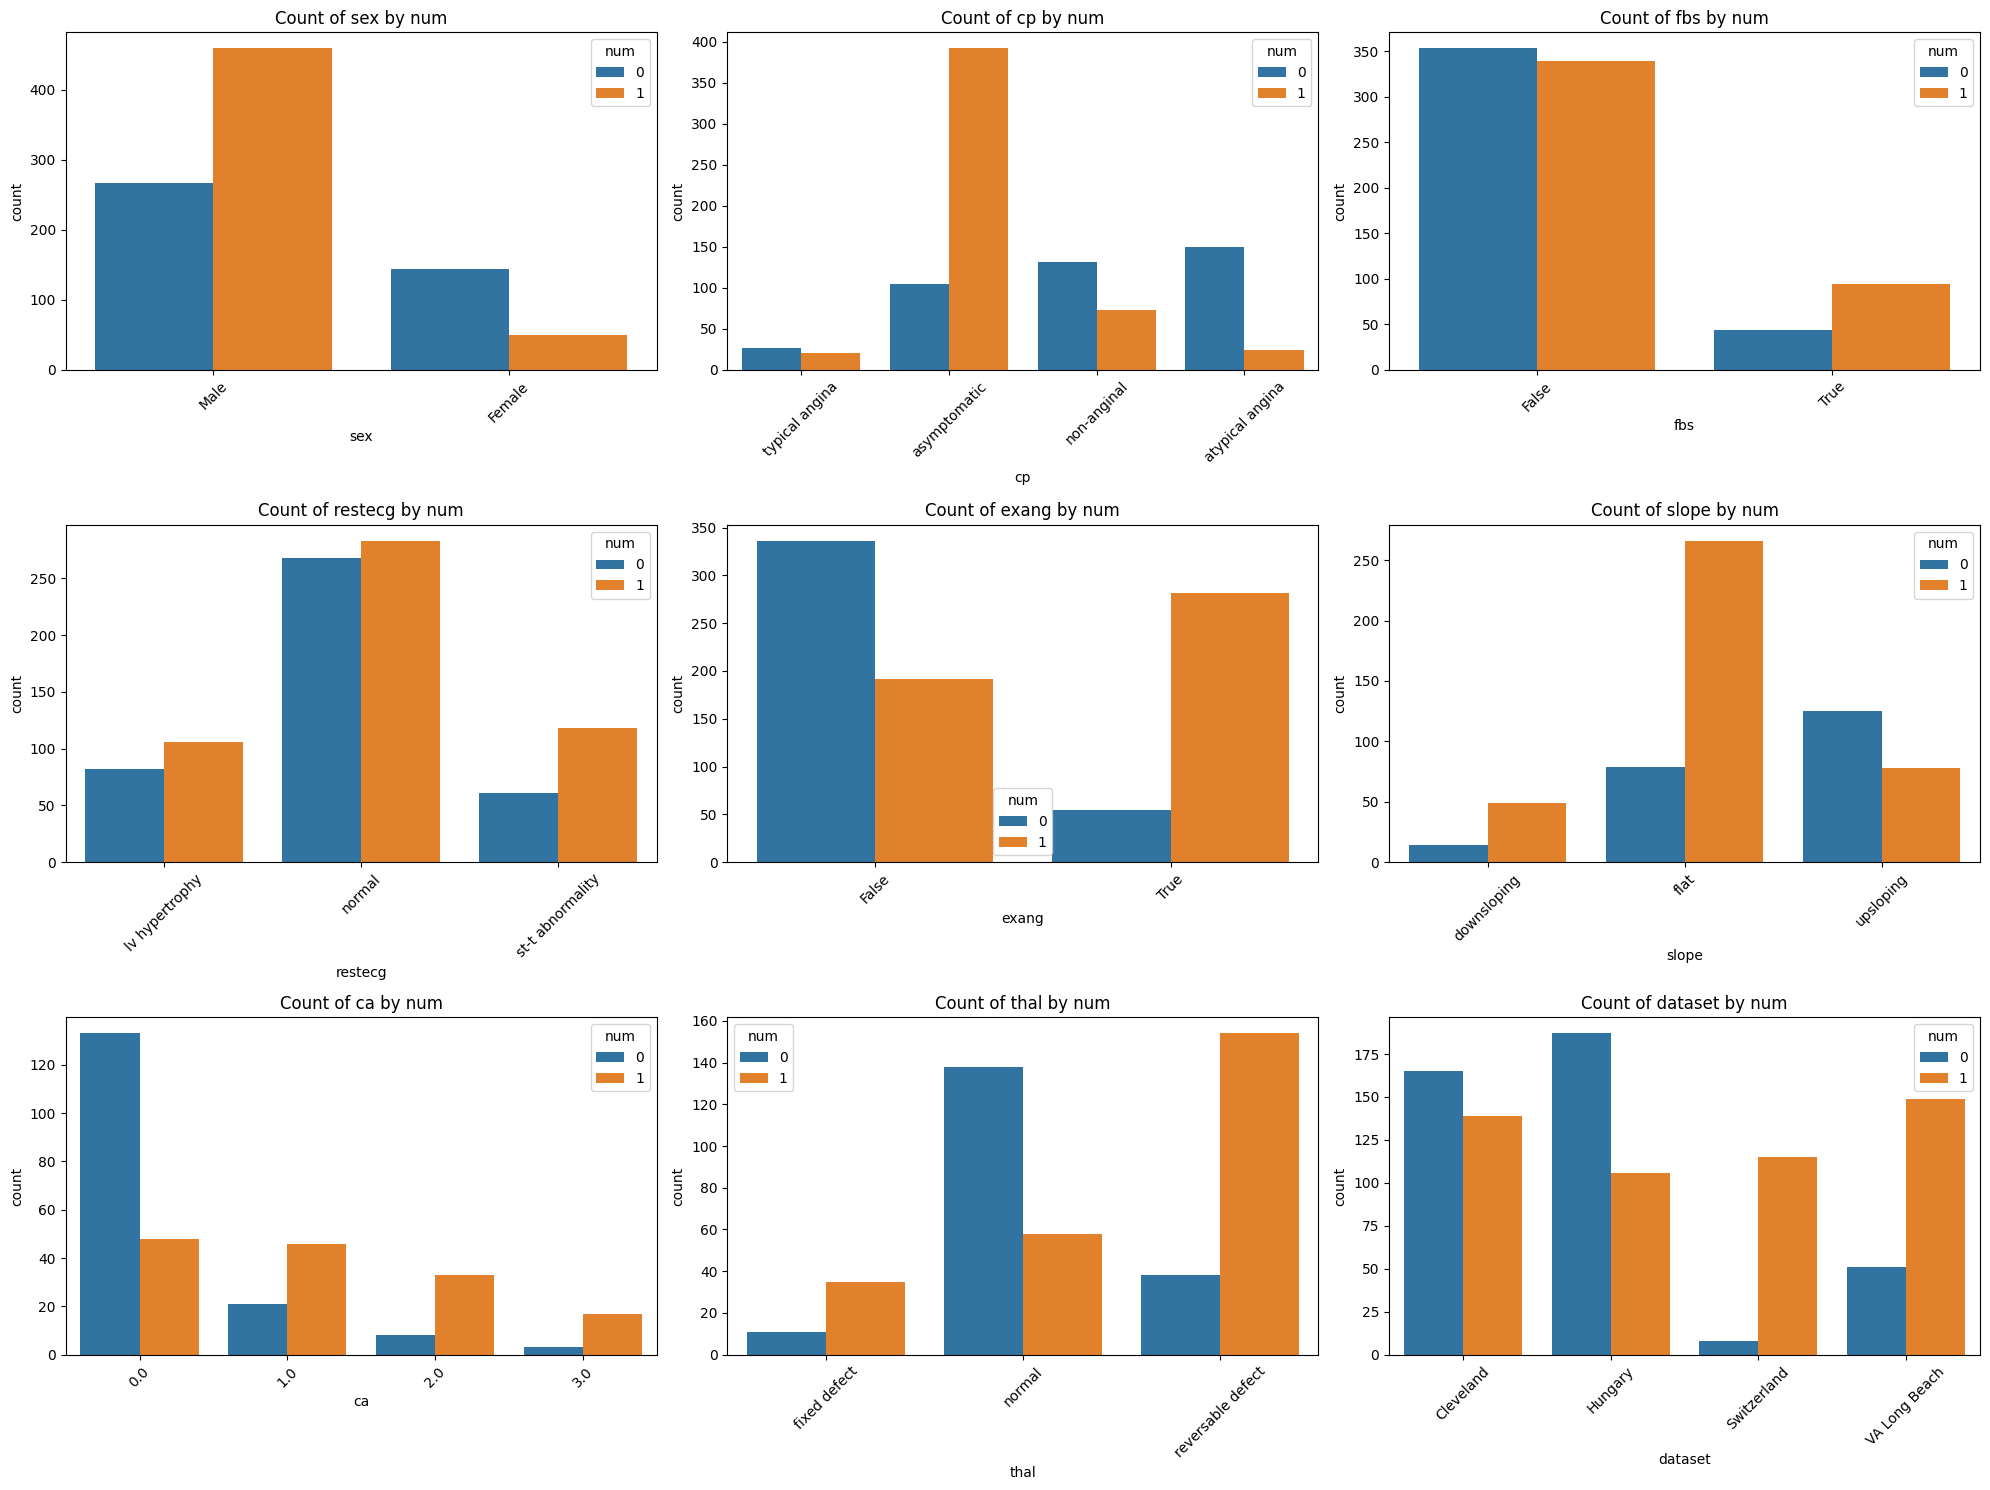

In [85]:
# Data Visualization
# Analyzing numerical features with boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='num', y=feature, data=heart_data)
    plt.title(f'Boxplot of {feature} by num')
plt.tight_layout()
plt.show()

# Analyzing categorical features with count plots
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    if i > 9:  # Skip after 9 plots to avoid overcrowding
        break
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='num', data=heart_data)
    plt.title(f'Count of {feature} by num')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

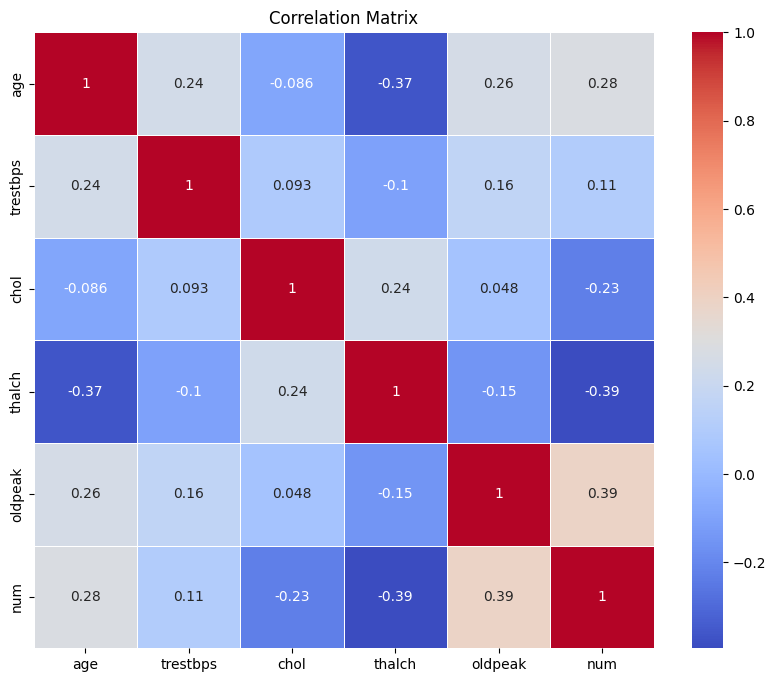

In [86]:
# Visualize correlations between features
plt.figure(figsize=(10, 8))
corr_matrix = heart_data[numeric_features + ['num']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

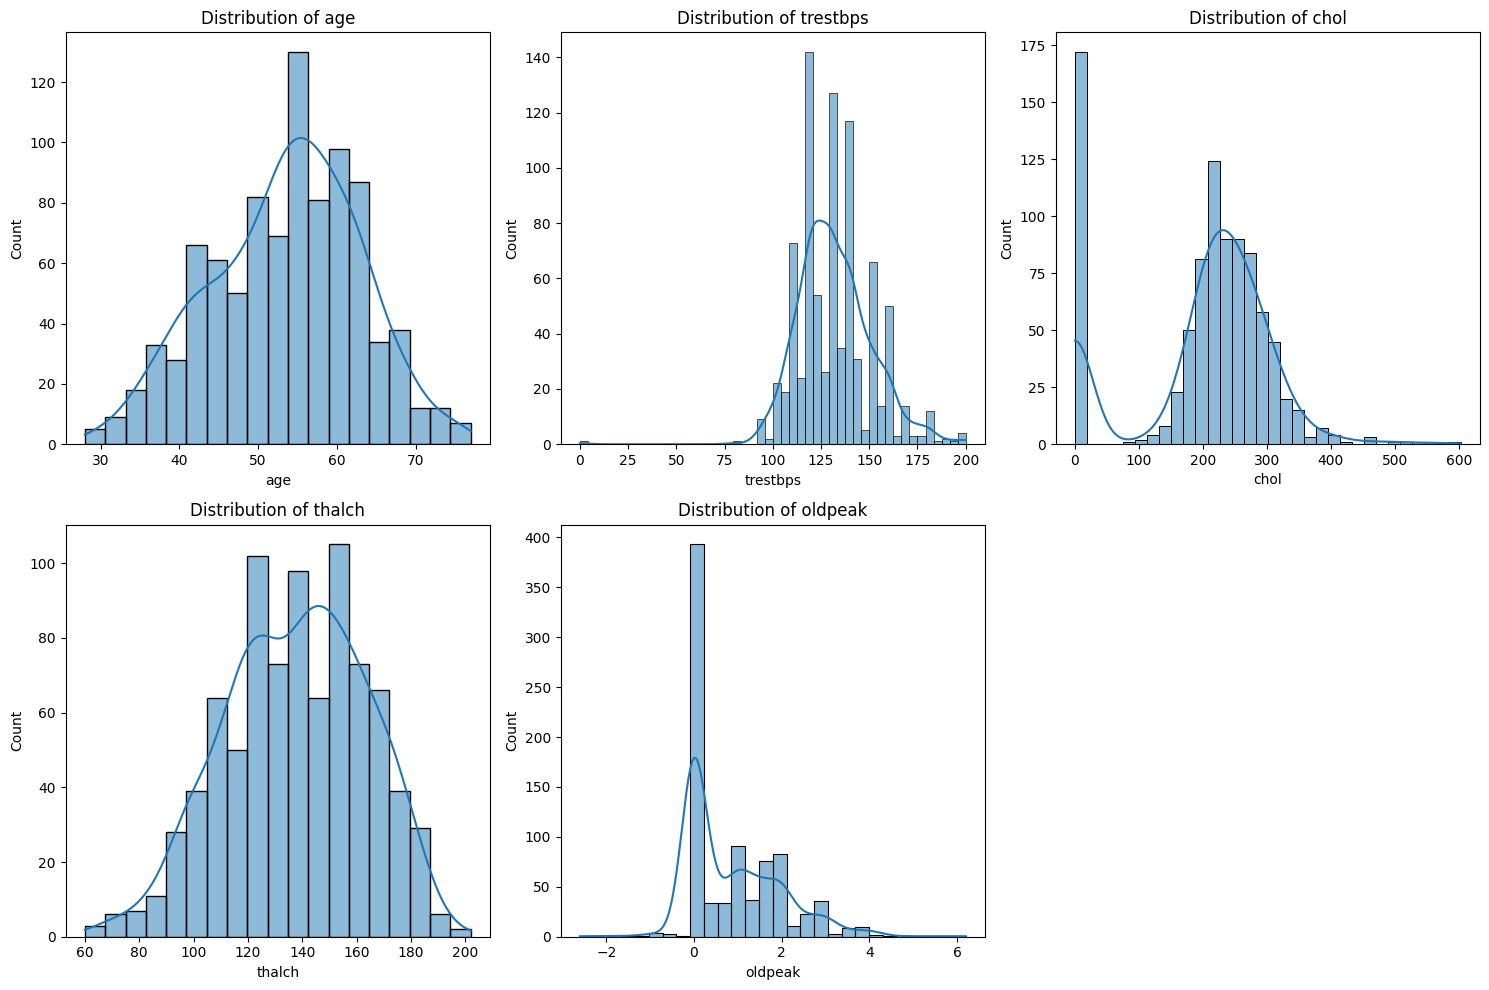

In [87]:
# Plot histograms for numerical variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(heart_data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [88]:
# Splitting the data into training and test sets
X = heart_data.drop('num', axis=1)
y = heart_data['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (736, 16)
Testing set shape: (184, 16)


In [89]:
## BASELINE MODEL BASED ON AGE GROUPS
# Calculate the baseline probabilities from the training data
age_probabilities = pd.DataFrame(y_train.groupby(X_train['age_group']).mean())
age_probabilities.columns = ['probability']
print("\nBaseline probabilities by age group:")
print(age_probabilities)

# Map these probabilities to the test data
X_test_baseline = X_test.copy()
X_test_baseline = X_test_baseline.merge(age_probabilities, left_on='age_group', right_index=True)

# Make predictions based on probability threshold
X_test_baseline['prediction'] = (X_test_baseline['probability'] > 0.5).astype(int)

# Create a confusion matrix for baseline model
baseline_cm = confusion_matrix(y_test, X_test_baseline['prediction'])
print("\nBaseline Model Confusion Matrix:")
print(baseline_cm)


Baseline probabilities by age group:
             probability
age_group               
middle aged     0.490196
older age       0.669173
young age       0.353261

Baseline Model Confusion Matrix:
[[50 32]
 [34 68]]


In [90]:
# Calculate metrics for baseline model
def calc_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1_score

baseline_accuracy, baseline_precision, baseline_recall, baseline_f1 = calc_metrics(baseline_cm)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Precision: {baseline_precision:.4f}")
print(f"Baseline Recall: {baseline_recall:.4f}")
print(f"Baseline F1 Score: {baseline_f1:.4f}")

Baseline Model Accuracy: 0.6413
Baseline Precision: 0.6800
Baseline Recall: 0.6667
Baseline F1 Score: 0.6733


In [91]:
# Calculate ROC and AUC for baseline model
fpr_base, tpr_base, _ = roc_curve(y_test, X_test_baseline['probability'])
roc_auc_base = auc(fpr_base, tpr_base)
print(f"Baseline AUC: {roc_auc_base:.4f}")


Baseline AUC: 0.6496


In [92]:
## MODEL PREPARATION
# Add age_group to categorical features for modeling
categorical_features_all = categorical_features + ['age_group']

# Create preprocessing pipelines for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())                    # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features_all)
    ])

In [93]:
## LOGISTIC REGRESSION MODEL
# Create a pipeline for Logistic Regression model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', C=0.1,
                                     random_state=42, max_iter=1000))
])

# Train the logistic regression model
print("\nTraining Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)


Training Logistic Regression model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal', 'dataset',
                                                   'age_group'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [94]:
# Feature importance for logistic regression
coefs = lr_pipeline.named_steps['classifier'].coef_[0]
top_coef_indices = np.argsort(np.abs(coefs))[-10:]  # Get indices of top 10 coefficients
print("\nTop 10 important features in Logistic Regression (by index):")
for i in top_coef_indices[::-1]:  # Reverse to show highest first
    print(f"Feature index {i}: coefficient = {coefs[i]:.4f}")


Top 10 important features in Logistic Regression (by index):
Feature index 6: coefficient = -1.2712
Feature index 21: coefficient = 0.9999
Feature index 12: coefficient = 0.7626
Feature index 7: coefficient = -0.6686
Feature index 5: coefficient = 0.5391
Feature index 4: coefficient = 0.4863
Feature index 3: coefficient = -0.3953
Feature index 18: coefficient = -0.1944
Feature index 0: coefficient = 0.1590
Feature index 20: coefficient = -0.1258


In [96]:
#Evaluate the logistic regression model
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

lr_cm = confusion_matrix(y_test, y_pred_lr)
lr_accuracy, lr_precision, lr_recall, lr_f1 = calc_metrics(lr_cm)

print("\nLogistic Regression Model Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Calculate ROC curve and AUC for logistic regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
print(f"AUC: {roc_auc_lr:.4f}")


Logistic Regression Model Results:
Accuracy: 0.8207
Precision: 0.8350
Recall: 0.8431
F1 Score: 0.8390
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80        82
           1       0.83      0.84      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184

AUC: 0.8908


In [97]:
## RANDOM FOREST MODEL
# Create a pipeline for Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10,
                                         min_samples_split=5, random_state=42))
])

# Train the random forest model
print("\nTraining Random Forest model...")
rf_pipeline.fit(X_train, y_train)


Training Random Forest model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal', 'dataset',
                                                   'age_group'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        random_state=42))])


Top 10 important features in Random Forest (by index):
Feature index 3: importance = 0.1368
Feature index 2: importance = 0.1165
Feature index 12: importance = 0.1116
Feature index 4: importance = 0.1088
Feature index 6: importance = 0.0901
Feature index 0: importance = 0.0689
Feature index 1: importance = 0.0540
Feature index 21: importance = 0.0400
Feature index 7: importance = 0.0359
Feature index 5: importance = 0.0345


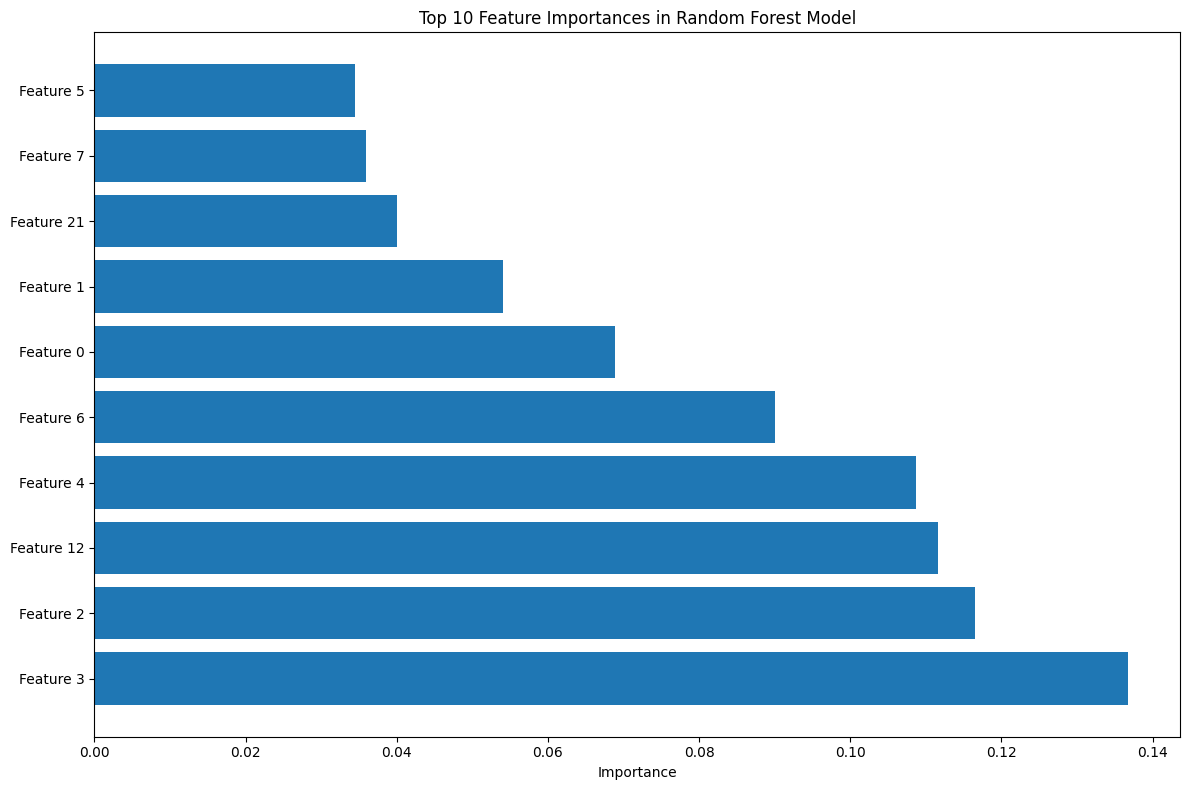

In [98]:
# Simplified feature importance for random forest
importances = rf_pipeline.named_steps['classifier'].feature_importances_
top_importance_indices = np.argsort(importances)[-10:]  # Get indices of top 10 features
print("\nTop 10 important features in Random Forest (by index):")
for i in top_importance_indices[::-1]:  # Reverse to show highest first
    print(f"Feature index {i}: importance = {importances[i]:.4f}")

# Plot feature importances by index
plt.figure(figsize=(12, 8))
top_indices = top_importance_indices[::-1]  # Reverse order
top_importances = importances[top_indices]
plt.barh(range(len(top_indices)), top_importances)
plt.yticks(range(len(top_indices)), [f"Feature {i}" for i in top_indices])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

In [99]:

# Evaluate random forest model
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_accuracy, rf_precision, rf_recall, rf_f1 = calc_metrics(rf_cm)

print("\nRandom Forest Model Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Model Results:
Accuracy: 0.7935
Precision: 0.8265
Recall: 0.7941
F1 Score: 0.8100
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        82
           1       0.83      0.79      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.79      0.79       184



In [100]:
# Calculate ROC curve and AUC for random forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"AUC: {roc_auc_rf:.4f}")

AUC: 0.8978


In [101]:
## NEURAL NETWORK MODEL
# For neural network, we need to preprocess the data first
# Apply preprocessing to training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Further split the processed training data to create a validation set
X_train_nn, X_val, y_train_nn, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [102]:
# Create a neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
print("\nTraining Neural Network model...")
history = model.fit(
    X_train_nn, y_train_nn,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Training Neural Network model...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6734 - loss: 0.6322 - val_accuracy: 0.7162 - val_loss: 0.5151
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7799 - loss: 0.4941 - val_accuracy: 0.7568 - val_loss: 0.4648
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7686 - loss: 0.5008 - val_accuracy: 0.7973 - val_loss: 0.4260
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8212 - loss: 0.4192 - val_accuracy: 0.7838 - val_loss: 0.4265
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8067 - loss: 0.4347 - val_accuracy: 0.7838 - val_loss: 0.3948
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8132 - loss: 0.4269 - val_accuracy: 0.8108 - val_loss: 0.3942
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8572 - loss: 0.3660 - val_accuracy: 0.7838 - val_loss: 0.3987
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8488 - loss: 0.376

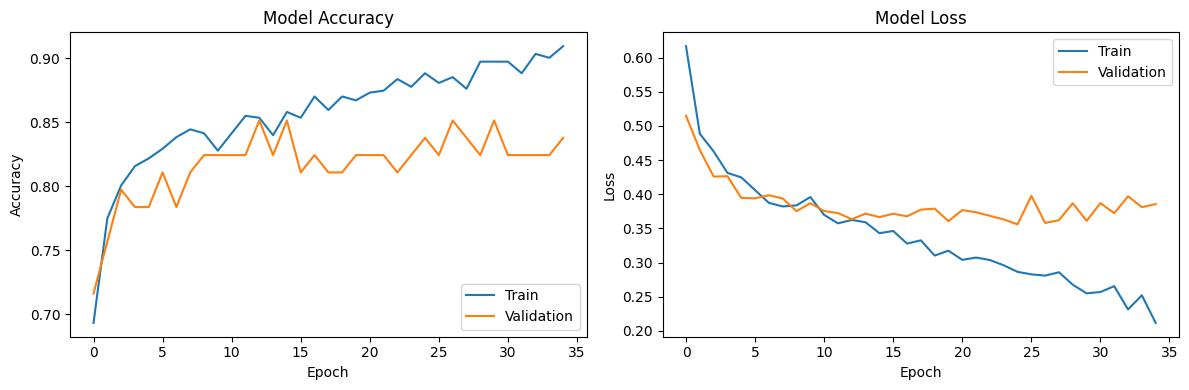

In [103]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [104]:
# Evaluate neural network
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test, verbose=0)
y_prob_nn = model.predict(X_test_processed).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

nn_cm = confusion_matrix(y_test, y_pred_nn)
nn_accuracy, nn_precision, nn_recall, nn_f1 = calc_metrics(nn_cm)

print("\nNeural Network Model Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1 Score: {nn_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nn))

# Calculate ROC curve and AUC for neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)
print(f"AUC: {roc_auc_nn:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Neural Network Model Results:
Accuracy: 0.8587
Precision: 0.8585
Recall: 0.8922
F1 Score: 0.8750
Test Loss: 0.4112
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        82
           1       0.86      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

AUC: 0.9077


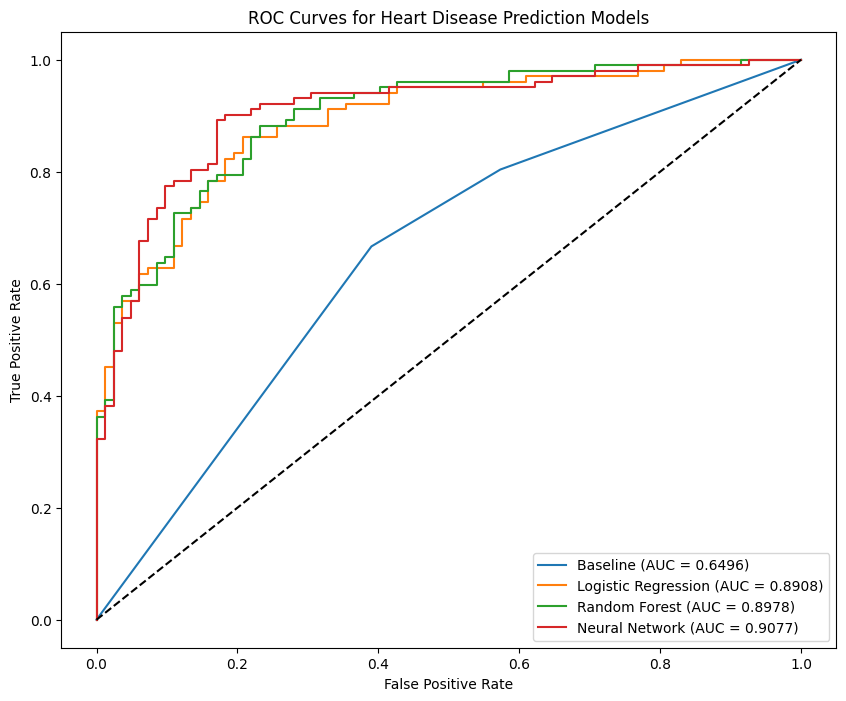

In [105]:
## COMPARE ALL MODELS
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {roc_auc_base:.4f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Heart Disease Prediction Models')
plt.legend(loc='lower right')
plt.show()

In [106]:
# Create a summary table of model performance
model_names = ['Baseline', 'Logistic Regression', 'Random Forest', 'Neural Network']
accuracies = [baseline_accuracy, lr_accuracy, rf_accuracy, nn_accuracy]
precisions = [baseline_precision, lr_precision, rf_precision, nn_precision]
recalls = [baseline_recall, lr_recall, rf_recall, nn_recall]
f1_scores = [baseline_f1, lr_f1, rf_f1, nn_f1]
aucs = [roc_auc_base, roc_auc_lr, roc_auc_rf, roc_auc_nn]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC': aucs
})
comparison_df = comparison_df.sort_values(by='AUC', ascending=False)
print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC
3       Neural Network  0.858696   0.858491  0.892157  0.875000  0.907700
2        Random Forest  0.793478   0.826531  0.794118  0.810000  0.897776
1  Logistic Regression  0.820652   0.834951  0.843137  0.839024  0.890842
0             Baseline  0.641304   0.680000  0.666667  0.673267  0.649570


In [107]:
# Identify the best model
best_model_index = np.argmax(aucs)
best_model_name = model_names[best_model_index]
print(f"\nBest Model: {best_model_name}")
print(f"With AUC: {aucs[best_model_index]:.4f}")
print(f"And Accuracy: {accuracies[best_model_index]:.4f}")


Best Model: Neural Network
With AUC: 0.9077
And Accuracy: 0.8587
